In [1]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term
Enable just-in-time compilation with XLA.




# Burger' s equation
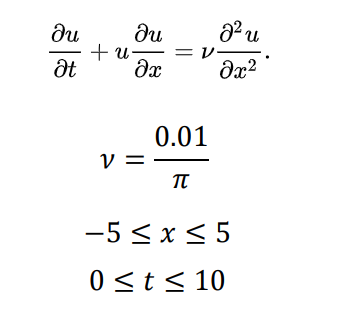

# Advection equation
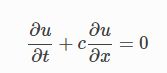

## Set C = 1
## I.C. = exp((x-2)(x-2))

In [2]:
def pde(x, u):
    du_x = tf.gradients(u, x)[0]
    du_x, du_t = du_x[:, 0:1], du_x[:,1:2]
    return (du_t + 1*du_x)


In [3]:
geom = dde.geometry.Interval(0, 150)
timedomain = dde.geometry.TimeDomain(0, 10)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)
#bc = 0
bc = dde.DirichletBC(geomtime, lambda x:0, lambda _, on_boundary: on_boundary)

#ic = -exp((x-2)(x-2))
ic = dde.IC(geomtime, lambda x: np.exp(-(x[:,0:1]-2)*(x[:,0:1]-2)), lambda _, on_initial: on_initial)

In [4]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain = 30000,
    num_boundary = 1000,
    num_initial = 2000
)

C:\Users\kozak\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+30002=30002. 
  warnings.warn("The balance properties of Sobol' points require "
C:\Users\kozak\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+1002=1002. 
  warnings.warn("The balance properties of Sobol' points require "
C:\Users\kozak\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+2002=2002. 
  warnings.warn("The balance properties of Sobol' points require "


Compiling model...
Building feed-forward neural network...
'build' took 0.099490 s



C:\Users\kozak\anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
C:\Users\kozak\anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 1.390693 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.18e-03, 2.39e-01, 4.05e-01]    [2.18e-03, 2.39e-01, 4.05e-01]    []  
1000      [5.73e-05, 2.45e-06, 3.07e-05]    [5.73e-05, 2.45e-06, 3.07e-05]    []  
2000      [1.45e-05, 5.94e-07, 4.56e-06]    [1.45e-05, 5.94e-07, 4.56e-06]    []  
3000      [3.72e-06, 3.80e-07, 2.31e-06]    [3.72e-06, 3.80e-07, 2.31e-06]    []  
4000      [2.09e-06, 4.41e-07, 2.02e-06]    [2.09e-06, 4.41e-07, 2.02e-06]    []  
5000      [1.15e-06, 4.45e-07, 1.49e-06]    [1.15e-06, 4.45e-07, 1.49e-06]    []  
6000      [1.00e-06, 2.39e-05, 4.38e-05]    [1.00e-06, 2.39e-05, 4.38e-05]    []  
7000      [8.65e-07, 3.47e-04, 5.22e-04]    [8.65e-07, 3.47e-04, 5.22e-04]    []  
8000      [7.82e-07, 1.15e-04, 6.53e-05]    [7.82e-07, 1.15e-04, 6.53e-05]    []  
9000      [3.30e-07, 3.43e-05, 6.47e-05]    [3.30e-07, 3.43e-05, 6.47e-05]    []  
10000   

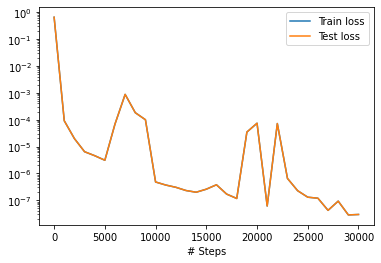

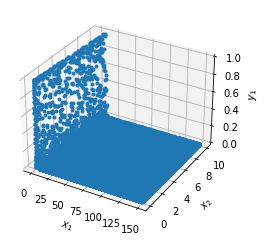

In [5]:
layers = [2] + [20]*3 + [30] + [1]

net = dde.maps.FNN(layers, "tanh", "Glorot normal")
model = dde.Model(data, net)
model.compile("adam", lr = 0.005)
losshistory, train_state = model.train(iterations = 30000)
dde.saveplot(losshistory, train_state, issave = False, isplot = True)

In [6]:
x_data = np.linspace(0, 10, num = 1000)
t_data = np.linspace(0, 10,num= 1000)
test_x, test_t = np.meshgrid(x_data, t_data)
test_domain = np.vstack((np.ravel(test_x), np.ravel(test_t))).T
predicted_solution = model.predict(test_domain)
residual = model.predict(test_domain, operator = pde)
predicted_solution = predicted_solution.reshape(1000, 1000)
residual = residual.reshape(1000, 1000)

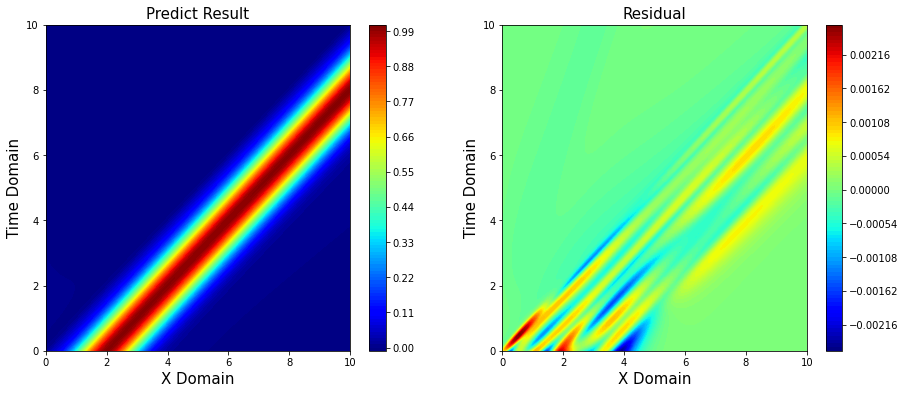

In [7]:
fig = plt.figure(figsize = (15, 6))
ax = fig.add_subplot(1, 2, 1)
ax.set_title("Predict Result", fontsize = 15)
ax.set_xlabel("X Domain", fontsize = 15)
ax.set_ylabel("Time Domain", fontsize = 15)
cs = ax.contourf(x_data, t_data, predicted_solution, 100, cmap = "jet")
cbar = fig.colorbar(cs)


ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("Residual", fontsize = 15)
ax2.set_xlabel("X Domain", fontsize = 15)
ax2.set_ylabel("Time Domain", fontsize = 15)
cs2 = ax2.contourf(x_data, t_data, residual, 100, cmap = "jet")
cbar2 = fig.colorbar(cs2)


plt.show()

In [8]:
zero_sec = predicted_solution[0,:]
two_sec = predicted_solution[200,:]
four_sec = predicted_solution[400,:]
six_sec = predicted_solution[600,:]
eight_sec = predicted_solution[800,:]
ten_sec = predicted_solution[999,:]
x_data_10 =np.linspace(0, 10, num = 1000)

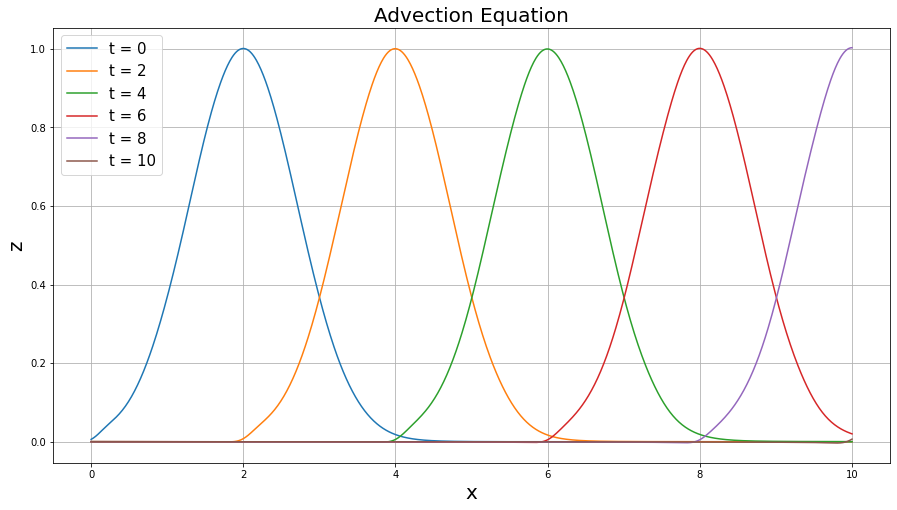

In [9]:
plt.close()
plt.figure(figsize = (15, 8))
plt.plot(x_data_10, zero_sec)
plt.plot(x_data_10, two_sec)
plt.plot(x_data_10, four_sec)
plt.plot(x_data_10, six_sec)
plt.plot(x_data_10, eight_sec)
plt.plot(x_data_10, ten_sec)
plt.grid()
plt.legend(('t = 0', 't = 2', 't = 4', 't = 6', 't = 8', 't = 10' ), fontsize = 15)
plt.xlabel('x', fontsize = 20)
plt.ylabel('z', fontsize = 20)
plt.title('Advection Equation', fontsize = 20)
plt.show()

In [10]:
import numpy as np    
import matplotlib.pyplot as plt

class LinearAdvection1D:
    # Matrix for LA1D 
   A=0
   # Initialization of constants 
   def __init__(self, c, x0, xN, N, deltaT,T):
      self.c = c 
      self.x0 = x0   
      self.xN = xN 
      self.N = N   
      self.deltaT = deltaT   
      self.T = T       
   # CFL number funct.   
   def CFL(self):
       deltaX= (self.xN - self.x0)/self.N
       return np.abs(self.c*self.deltaT/deltaX)
   # check CFL number <=1 or not.
   def checkCFL(self):
       if (self.CFL()<=1):
           flag=True 
       else:
           flag=False
       return flag
   # Matrix assembly of LA1D   
   def upwindMatrixAssembly(self):
       alpha_min=min(self.CFL(),0)
       alpha_max=max(self.CFL(),0)
       a1=[alpha_max]*(self.N-1)
       a2=[1+alpha_min-alpha_max]*(self.N)
       a3=[-alpha_min]*(self.N-1)
       self.A=np.diag(a1, -1)+np.diag(a2, 0)+np.diag(a3, 1)
       self.A[0,-1]=alpha_max
       self.A[N-1,0]=-alpha_min
   # Solve u=Au0
   def Solve(self,u0):
       return np.matmul(self.A,u0)     

In [11]:
#############  
# Start of the code
###################

# constants  t = 0
N,x0,xN,deltaT,c,T=100,0.,10.,0.01,1,0
# initialization of constants
LA1D = LinearAdvection1D(c, x0, xN, N, deltaT,T) 

# initial value
x=np.linspace(LA1D.x0,LA1D.xN,LA1D.N)
u0=np.exp(-(x-2)*(x-2))


# calculating solution if CFL<=1
if (LA1D.checkCFL() is True):
    LA1D.upwindMatrixAssembly()
    for t in range(0,int(LA1D.T/LA1D.deltaT)):
        u=LA1D.Solve(u0)
        u0=u

In [12]:
#############  
# Start of the code
###################

# constants  t = 0
N,x0,xN,deltaT,c,T=100,0.,10.,0.01,1,2
# initialization of constants
LA1D = LinearAdvection1D(c, x0, xN, N, deltaT,T) 

# initial value
x=np.linspace(LA1D.x0,LA1D.xN,LA1D.N)
u1=np.exp(-(x-2)*(x-2))


# calculating solution if CFL<=1
if (LA1D.checkCFL() is True):
    LA1D.upwindMatrixAssembly()
    for t in range(0,int(LA1D.T/LA1D.deltaT)):
        u=LA1D.Solve(u1)
        u1=u

In [13]:
#############  
# Start of the code
###################

# constants  t = 0
N,x0,xN,deltaT,c,T=100,0.,10.,0.01,1,4
# initialization of constants
LA1D = LinearAdvection1D(c, x0, xN, N, deltaT,T) 

# initial value
x=np.linspace(LA1D.x0,LA1D.xN,LA1D.N)
u2=np.exp(-(x-2)*(x-2))


# calculating solution if CFL<=1
if (LA1D.checkCFL() is True):
    LA1D.upwindMatrixAssembly()
    for t in range(0,int(LA1D.T/LA1D.deltaT)):
        u=LA1D.Solve(u2)
        u2=u

In [14]:
#############  
# Start of the code
###################

# constants  t = 0
N,x0,xN,deltaT,c,T=100,0.,10.,0.01,1,6
# initialization of constants
LA1D = LinearAdvection1D(c, x0, xN, N, deltaT,T) 

# initial value
x=np.linspace(LA1D.x0,LA1D.xN,LA1D.N)
u3=np.exp(-(x-2)*(x-2))


# calculating solution if CFL<=1
if (LA1D.checkCFL() is True):
    LA1D.upwindMatrixAssembly()
    for t in range(0,int(LA1D.T/LA1D.deltaT)):
        u=LA1D.Solve(u3)
        u3=u

In [15]:
#############  
# Start of the code
###################

# constants  t = 0
N,x0,xN,deltaT,c,T=100,0.,10.,0.01,1,8
# initialization of constants
LA1D = LinearAdvection1D(c, x0, xN, N, deltaT,T) 

# initial value
x=np.linspace(LA1D.x0,LA1D.xN,LA1D.N)
u4=np.exp(-(x-2)*(x-2))


# calculating solution if CFL<=1
if (LA1D.checkCFL() is True):
    LA1D.upwindMatrixAssembly()
    for t in range(0,int(LA1D.T/LA1D.deltaT)):
        u=LA1D.Solve(u4)
        u4=u

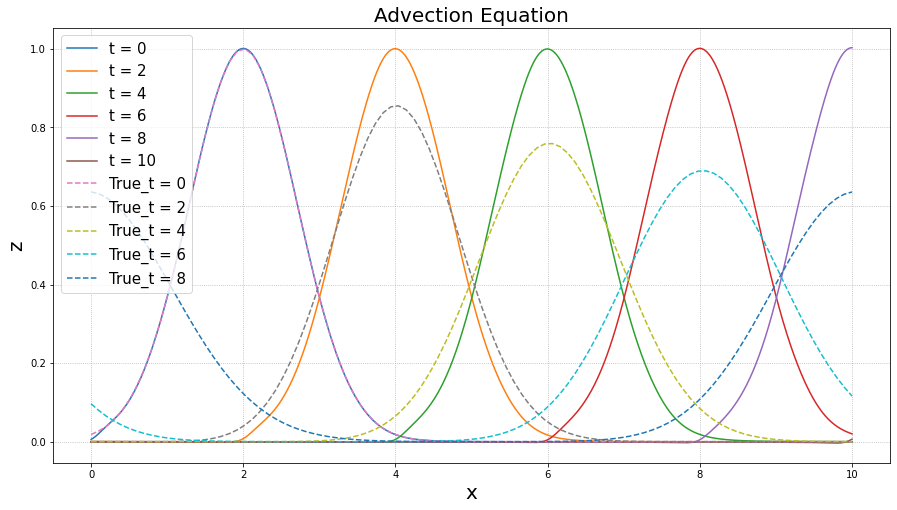

In [16]:
        
################################################    
        
# ploting the last solution
#####
plt.close()
plt.figure(figsize = (15, 8))
plt.plot(x_data, zero_sec)
plt.plot(x_data, two_sec)
plt.plot(x_data, four_sec)
plt.plot(x_data, six_sec)
plt.plot(x_data, eight_sec)
plt.plot(x_data, ten_sec)
plt.plot(x,u0, '--')
plt.plot(x,u1, '--')
plt.plot(x,u2, '--')
plt.plot(x,u3, '--')
plt.plot(x,u4, '--')

plt.grid()
plt.legend(('t = 0', 't = 2', 't = 4', 't = 6', 't = 8', 't = 10','True_t = 0','True_t = 2','True_t = 4','True_t = 6','True_t = 8' ), fontsize = 15)
plt.xlabel('x', fontsize = 20)
plt.ylabel('z', fontsize = 20)
plt.title('Advection Equation', fontsize = 20)


#####

plt.grid(linestyle='dotted')

plt.show()

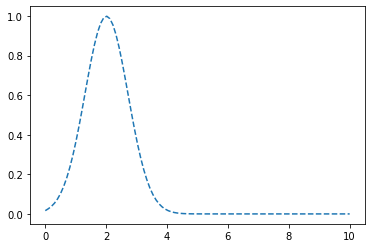